<img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> University of Haifa - Computer Vision course


## Homework 2 - 3D Vision
---

### <a style='color:red'> Due Date: Thursday 12.6.2025 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**, unless you have already got an approval to work on your own

* Submission is only through Moodle

* You can choose your working environment:
    * `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
        * Colab also supports running code on GPU, but you will not need it for this excercise.
    * Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both allow editing and running Jupyter Notebooks.
<div style="margin-top:6px;"></div>

* You should submit only this ipynb notebook file, **with all cells executed such that the results will be included**.
<div style="margin-top:6px;"></div>

* Read the instructions carefully:
    * You have functions to complete and scripts to write - look for <span style="color:red">''' YOUR CODE HERE '''</span>
        * Make sure to properly document your code
        * Notice where you can use existing implementations (e.g. opencv) freely and in which cases you have to provide your own implementation of certain steps
    * You have some explanations and discussions to write - look for <span style="color: red; font-weight: bold;">YOUR EXPLANATION\DISCUSSION HERE</span>
        * Make sure to answer shortly but informatively
<div style="margin-top:6px;"></div>

* Code of Honor:
    * We wish to avoid dealing with copied homework. However, we will not hesitate to take serious actions against students that are caught with violations of the Honor Code. Note that in this course, it is rather easy to detect similar submissions, as most of them require your "personal" touch.     
<div style="margin-top:6px;"></div>

* Submission date:
    * Submission date of 12.6.2025 is final and will not be delayed
    * However, you may submit up to 2 days late (till Sunday 14.6.2025) at the cost of 4 points per day
    * Any (fully justified and documented) requests for delay must be sent till Sunday 8.6 at the latest
    * The excercise is long and isn't easy - **make sure to start early**


### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `opencv` (or `scikit-image`)
* `scikit-learn`
* `scipy`
* Anything else you need (`os`, `pandas`, `csv`, `json`,...)

# <font color="red">IMPORTANT:</font> Make sure that each output image has a title to it.

# Part 1 - Constraining putative matches using geometry
---

### Implement the functions below (separately), given a pair of images to be matched:

## 1. Obtain SIFT-based matches
* Compute SIFT features in each of the images
* Perform SIFT matching between the two sets of features, to obtain a set of matches M

## 2. Visualize a set of matches
* Visualize the image pair, side-by-side, with thin lines connecting matching points (You may visualize a large random subset, if there are too many matches and the result is too cluttered)

## 3. Recover the Epipolar geometry
* Given the set of matches, estimate a Fundamental matrix F

## 4. Visualize the Epipolar geometry
* Given F, sample 10 2D points, uniformly at random, in image 1 and compute (using F), the epipolar lines in image 2.
* Visualize the image pair, side-by-side. Choose 10 unique different colors (preferably spread uniformly over some colorspace) and then use colored markers to overlay the points in image 1 and the corresponding colors to overlay the epipolar lines in image 2.
* Repeat the above, by switching roles (random points in image 2 and matching epipoles in image 1).

## 5. Constrain a set of matches, by filtering them with the obtained geometry
* Find and return the subset M' of the original set of matches M, that 'agree' with the obtained F, up to some error threshold.


### Using the above functions, for each pair of images in data/pairs_to_match, perform the following:
* Visualize a simple SIFT-based set of matches
* Estimate the fundamental matrix F and visualize the epipolar geometry
* Constrain the set of matches using F and visualize the result.
* Do you observe that constraining the matches to the epipolar geometry (given by F) is helpful in any way? (Was it able to filter out all of the outliers? Did it filter out any inliers?). Explain in the second cell below.



In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os


# 1.
def sift_init_match(img1, img2, ratio_thresh=0.75):
    sift = cv2.SIFT_create()

    # Detect and compute keypoints/descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters for fast approximate matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # kNN match: find top 2 matches for each descriptor
    knn_matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Optionally, limit to the best 150 matches by distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    return kp1, kp2, good_matches


# 2.
def visualize_matches(img1, img2):
    kp1, kp2, matches = sift_init_match(img1,img2)
    match_img = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        matches,
        None,
        matchColor=(0,255,0),
        singlePointColor=None,
        matchesThickness=2
    )

    h1, w1 = img1.shape[:2]
    circle_radius=15
    circle_thickness=2
    circle_color=(0,255,255)

    for m in matches:
        # pt in image1
        (x1, y1) = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        cv2.circle(match_img, (x1, y1), circle_radius, circle_color, circle_thickness)

        # pt in image2 (shift x by w1)
        (x2, y2) = tuple(np.round(kp2[m.trainIdx].pt).astype(int))
        cv2.circle(match_img, (x2 + w1, y2), circle_radius, circle_color, circle_thickness)

    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Matches ({len(matches)} shown)')
    plt.axis('off')
    plt.show()

# 3.1.
def normalize_points(match):
    mean = np.mean(match, axis=0)
    std = np.std(match)

    scale = np.sqrt(2) / std
    T = np.array([
        [scale, 0, -scale * mean[0]],
        [0, scale, -scale * mean[1]],
        [0,     0,               1]
    ])

    # Convert to homogeneous and normalize
    match_homog = np.hstack([match, np.ones((match.shape[0], 1))])  # (N, 3)
    normalized_homog = (T @ match_homog.T).T

    return normalized_homog[:, :2], T
# 3.2.
def ransac_fundamental_eight_point(match1, match2, threshold=1.0, iterations=5000):
    def normalize_points(points):
        mean = np.mean(points, axis=0)
        std = np.std(points)
        T = np.array([[1/std, 0, -mean[0]/std],
                      [0, 1/std, -mean[1]/std],
                      [0, 0, 1]])
        points_h = np.hstack((points, np.ones((points.shape[0], 1))))
        points_norm = (T @ points_h.T).T[:, :2]
        return points_norm, T

    best_F = None
    best_inliers = []
    max_inliers = 0
    N = match1.shape[0]

    for _ in range(iterations):
        idx = np.random.choice(N, 8, replace=False)
        pts1_sample = match1[idx]
        pts2_sample = match2[idx]

        # Normalize
        pts1_norm, T1 = normalize_points(pts1_sample)
        pts2_norm, T2 = normalize_points(pts2_sample)

        # Build A matrix
        A = np.zeros((8, 9))
        for i in range(8):
            u1, v1 = pts1_norm[i]
            u2, v2 = pts2_norm[i]
            A[i] = [u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1]

        # Solve Af=0 using SVD
        try:
            _, _, Vt = np.linalg.svd(A)
            F = Vt[-1].reshape(3, 3)

            # Enforce rank 2
            U, S, VtF = np.linalg.svd(F)
            S[2] = 0
            F_rank2 = U @ np.diag(S) @ VtF

            # Denormalize
            F_denorm = T2.T @ F_rank2 @ T1
        except np.linalg.LinAlgError:
            continue  # skip ill-conditioned samples

        # Epipolar distance
        match1_h = np.hstack((match1, np.ones((N, 1))))
        match2_h = np.hstack((match2, np.ones((N, 1))))
        lines2 = (F_denorm @ match1_h.T).T  # each row: a*x + b*y + c = 0

        a, b, c = lines2[:, 0], lines2[:, 1], lines2[:, 2]
        x2, y2 = match2[:, 0], match2[:, 1]
        dists = np.abs(a * x2 + b * y2 + c) / np.sqrt(a**2 + b**2)

        inliers = np.where(dists < threshold)[0]

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_F = F_denorm
            best_inliers = inliers

    # Optional: refine using all inliers
    if best_F is not None and len(best_inliers) >= 8:
        pts1_in = match1[best_inliers]
        pts2_in = match2[best_inliers]
        pts1_norm, T1 = normalize_points(pts1_in)
        pts2_norm, T2 = normalize_points(pts2_in)
        A = np.zeros((len(pts1_in), 9))
        for i in range(len(pts1_in)):
            u1, v1 = pts1_norm[i]
            u2, v2 = pts2_norm[i]
            A[i] = [u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1]
        _, _, Vt = np.linalg.svd(A)
        F = Vt[-1].reshape(3, 3)
        U, S, VtF = np.linalg.svd(F)
        S[2] = 0
        F_rank2 = U @ np.diag(S) @ VtF
        best_F = T2.T @ F_rank2 @ T1

    return best_F, best_inliers

# 4.

def compute_epipolar_lines(img1, img2, F, num_points=10):
    H, W, _ = img1.shape
    
    # Points in image 1 and their corresponding epipolar lines in image 2
    points1 = np.hstack((
        np.random.uniform(0, W, (num_points, 1)),
        np.random.uniform(0, H, (num_points, 1)),
        np.ones((num_points, 1))
    ))  # shape (num_points, 3)

    lines2 = (F @ points1.T).T  # Epipolar lines in image 2

    # Points in image 2 and their corresponding epipolar lines in image 1
    points2 = np.hstack((
        np.random.uniform(0, W, (num_points, 1)),
        np.random.uniform(0, H, (num_points, 1)),
        np.ones((num_points, 1))
    ))

    lines1 = (F.T @ points2.T).T  # Epipolar lines in image 1

    return points1, lines2, points2, lines1


def draw_epipolar_lines(img1, img2, points1, lines2, points2, lines1):
    H, W, _ = img1.shape
    num_points = points1.shape[0]
    colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_points))

    # First plot: points1 on img1, lines2 on img2
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[0].set_title("Image 1: Points")
    axes[1].set_title("Image 2: Epipolar Lines")

    for ax in axes:
        ax.set_xlim(0, W)
        ax.set_ylim(H, 0)
        ax.set_aspect('equal')
        ax.axis('off')

    for i in range(num_points):
        x, y = points1[i][:2]
        a, b, c = lines2[i]
        color = colors[i]
        axes[0].plot(x, y, 'o', color=color, markersize=6)
        x_vals = np.array([0, W])
        if abs(b) > 1e-6:
            y_vals = -(a * x_vals + c) / b
            axes[1].plot(x_vals, y_vals, color=color)
        else:
            x_line = -c / a
            axes[1].axvline(x=x_line, color=color)

    plt.tight_layout()
    plt.show()

    # Second plot: points2 on img2, lines1 on img1
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[0].set_title("Image 1: Epipolar Lines")
    axes[1].set_title("Image 2: Points")

    for ax in axes:
        ax.set_xlim(0, W)
        ax.set_ylim(H, 0)
        ax.set_aspect('equal')
        ax.axis('off')

    for i in range(num_points):
        x, y = points2[i][:2]
        a, b, c = lines1[i]
        color = colors[i]
        axes[1].plot(x, y, 'o', color=color, markersize=6)
        x_vals = np.array([0, W])
        if abs(b) > 1e-6:
            y_vals = -(a * x_vals + c) / b
            axes[0].plot(x_vals, y_vals, color=color)
        else:
            x_line = -c / a
            axes[0].axvline(x=x_line, color=color)

    plt.tight_layout()
    plt.show()
    
# 5.
def filter_matches_by_F(matches, F, threshold=1e-3):
    agreeMatches = []

    for (pt1, pt2) in matches:
        #convert to homogeneous points
        x1 = np.array([pt1[0], pt1[1], 1])
        x2 = np.array([pt2[0], pt2[1], 1])

        error = abs(x2.T @ F @ x1)
        if error < threshold:
            agreeMatches.append((pt1, pt2))

    return np.array(agreeMatches)


folder_path = 'data/pairs_to_match'

# Get list of image files
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]


'''
# Process image pairs
for i in range(0, len(image_files), 2):
    img1_path = os.path.join(folder_path, image_files[i])
    img2_path = os.path.join(folder_path, image_files[i + 1])

    print(f"\nProcessing pair: {image_files[i]} and {image_files[i + 1]}")

    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)


    #initial SIFT matches
    kp1, kp2, matches = sift_init_match(img1, img2)
    visualize_matches(img1,img2)

    #Estimate Fundamental Matrix
    match_pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    match_pts2 = np.array([kp2[m.trainIdx].pt for m in matches])
    F,_ = ransac_fundamental_eight_point(match_pts1, match_pts2)

    #Visualize epipolar geometry
    points1, lines2, points2, lines1 = compute_epipolar_lines(img1, img2, F)
    draw_epipolar_lines(img1, img2, points1, lines2, points2, lines1)
    
    #Filter matches using F
    filtered_matches = filter_matches_by_F(zip(match_pts1, match_pts2), F, threshold=1e-3)

    #Draw filtered matches
    filtered_kp1 = [cv2.KeyPoint(x=pt1[0], y=pt1[1], size=1) for pt1, _ in filtered_matches]
    filtered_kp2 = [cv2.KeyPoint(x=pt2[0], y=pt2[1], size=1) for _, pt2 in filtered_matches]
    final_matches = [cv2.DMatch(i, i, 0) for i in range(len(filtered_matches))]

    match_img_filtered = cv2.drawMatches(img1, filtered_kp1, img2, filtered_kp2, final_matches, None)
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(match_img_filtered, cv2.COLOR_BGR2RGB))
    plt.title(f'Matches After Filtering with F ({len(filtered_matches)} remain)')
    plt.axis('off')
    plt.show()
'''


'\n# Process image pairs\nfor i in range(0, len(image_files), 2):\n    img1_path = os.path.join(folder_path, image_files[i])\n    img2_path = os.path.join(folder_path, image_files[i + 1])\n\n    print(f"\nProcessing pair: {image_files[i]} and {image_files[i + 1]}")\n\n    # Load images\n    img1 = cv2.imread(img1_path)\n    img2 = cv2.imread(img2_path)\n\n\n    #initial SIFT matches\n    kp1, kp2, matches = sift_init_match(img1, img2)\n    visualize_matches(img1,img2)\n\n    #Estimate Fundamental Matrix\n    match_pts1 = np.array([kp1[m.queryIdx].pt for m in matches])\n    match_pts2 = np.array([kp2[m.trainIdx].pt for m in matches])\n    F,_ = ransac_fundamental_eight_point(match_pts1, match_pts2)\n\n    #Visualize epipolar geometry\n    points1, lines2, points2, lines1 = compute_epipolar_lines(img1, img2, F)\n    draw_epipolar_lines(img1, img2, points1, lines2, points2, lines1)\n    \n    #Filter matches using F\n    filtered_matches = filter_matches_by_F(zip(match_pts1, match_pts2), 

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

# Part 2 - Middle-View synthesis from a rectified stereo pair.
---

### In this section, given a *rectified* image pair, we wish to generate/synthesize the image that would have been captured by a camera situated exactly in the middle, between the pair of poses.

## We will follow two different strategies to do so:
* Strategy A: Via photometric stereo
* Strategy B: Via sparse reconstruction

## Details for Strategy A:
* Compute a (dense) disparity map between the pair of images: **Implement your own (don't use a ready library function for this)**
* Use this map to synthesize the 'central' image
* Explain what problems arise in this approach and how your solution tries to deal with them

## Details for Strategy B:
* Use the code from the previous parts to obtain a set of matches - ones that obeys with the geometry. How would you do this even without knowing the fundamental matrix?
* Using triangulation, find the locations of the interest points in the new 'central' image (In practice - this can be done by simply using the disparity for each match). At this point - You should have 'triplet' matches, each consisting of 1 point in each of the 3 viewpoints.
* Take the set of (match) points in one of the images (left, right or middle - to your choice) and sub-divide the image into small triangular or quadrilateral sub-regions, whose vertices are placed on the matched interest points. This can be done, for example, by computing any kind of triangulation over the interest points (see the 'Dylan' example under the 'Examples' folder). Once obtaining the subdivision (e.g. triangulation), it can be transfered to the other two images, using the corresponding matching points.
* For each region (triangle or quadrilateral), copy the contents from one of the input images to the target (middle) image, using either an affine transformation (for a triangle) or a homography (for a quadrilateral).
* Explain what problems arise in this approach and how your solution tries to deal with them.

## Implement your solutions and expain them in the following 4 cells.


In [ ]:
# ALL OF YOUR CODE FOR STATEGY A SHOULD BE IN THIS CELL

# REQUIRED OUTPUTS (For each of the input stereo pairs in data/rectified_pairs):
# 1. Visualize, side-by-side: left-image | right-image
# 2. Visualize, side-by-side: left-disparity-image | right_disparity-image
# 3. Visualize, by constructing an infinite-loop GIF of the four images: img_1->img_mid->img_2->img_mid->,
#    using the following given function:

import imageio
from IPython.display import Image

def create_and_display_gif(image_files, gif_path='animation.gif', duration=0.5):
    """
    Creates a GIF from a list of image files and displays it in a Jupyter notebook.

    Parameters:
    - image_files (list of str): Paths to the input image files.
    - gif_path (str): Path where the output GIF will be saved.
    - duration (float): Duration per frame in seconds.

    Returns:
    - IPython.display.Image object displaying the GIF.
    """
    with imageio.get_writer(gif_path, mode='I', duration=duration) as writer:
        for filename in image_files:
            image = imageio.imread(filename)
            writer.append_data(image)

    return Image(filename=gif_path)

# example usage:
# image_files = ['frame_1.jpg', 'frame_middle.jpg', 'frame_2.jpg', 'frame_middle.jpg'] 
# create_and_display_gif(image_files, gif_path='my_gif.gif', duration=0.5)

"""
YOUR CODE HERE
"""

### Explanation of your solution (short, in bullets) and interpretation of results of strategy A:

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

In [ ]:
# ALL OF YOU CODE FOR STATEGY B SHOULD BE IN THIS CELL

# REQUIRED OUTPUTS (For each of the input stereo pairs in data/rectified_pairs):
# 1. Visualize, side-by-side: left-image | right-image (both with match-points overlaid on them - using small markers)
# 2. Visualize, side-by-side: left-image | white-image | right image (with overlayed corresponding subdivisions)
# 3. Visualize, by constructing an infinite-loop GIF of the four images: img_1->img_mid->img_2->img_mid->
 
"""
YOUR CODE HERE
"""

### Explanation of your solution (short, in bullets) and interpretation of results of strategy B:

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

# Part 3 - Motion Segmentation
---

### In this section, you are given a pair of images, taken from two different viewpoints, at different times. The captured scene is known to be static, except for a single rigid (non-flexible) object that has moved between the two  captures. Your goal is to 'segment' (classify) the set of matches between the images, as belonging to either 'static' (background) or 'dynamic' (moving object) or 'outliers' (inconsistent).

## Instructions
* Use only the functions that you had implemented in part 1
* Show results for the image pair under the 'data/pairs_to_segment' folder
* Capture yourselves two additional image pairs, save them in that same folder, and produce results for them too.


## Required Visualization (for each image pair):
-- See the 'segmentation' solution outputs under the 'examples' folder
* Show the image pair, with 'outlier' matches overlaid (show only a random subset if there are too many)
* Show the image pair, with 'static' matches overlaid (show only a random subset if there are too many)
* Show the image pair, with 'dynamic' matches overlaid (show only a random subset if there are too many

## Implement your solution in the next cell and explain it in short in the following one.


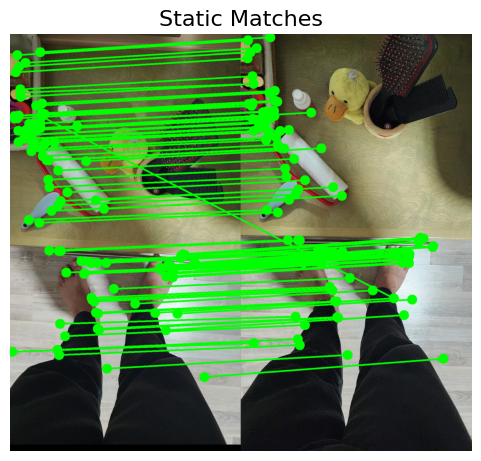

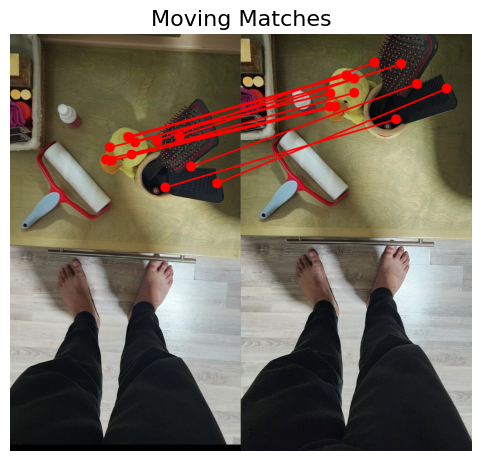

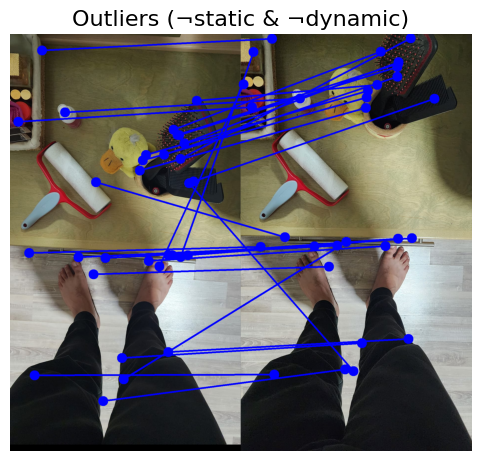

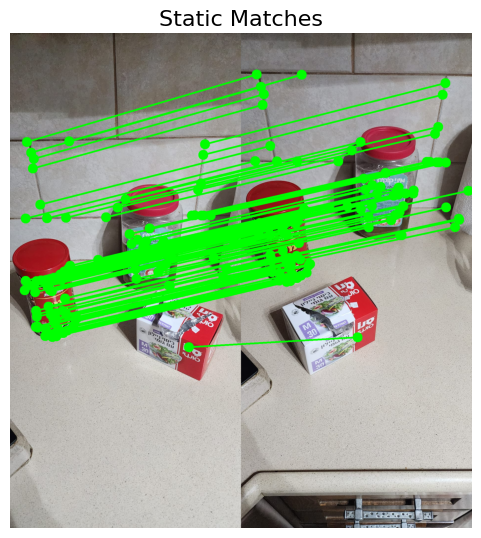

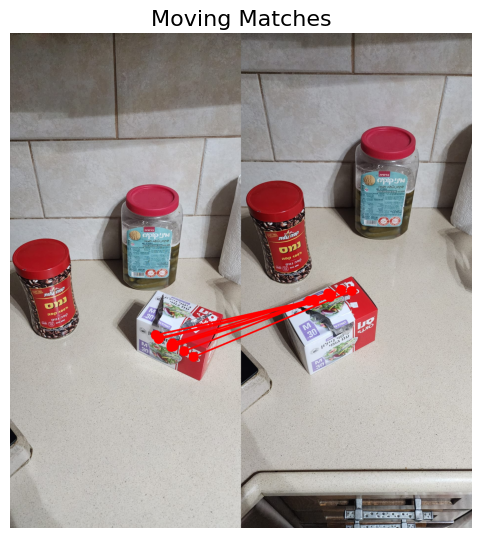

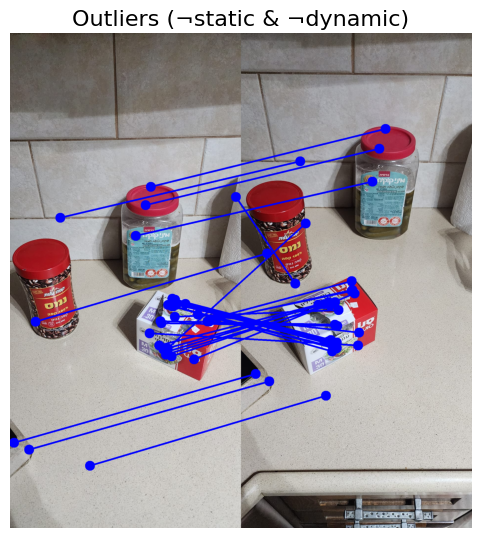

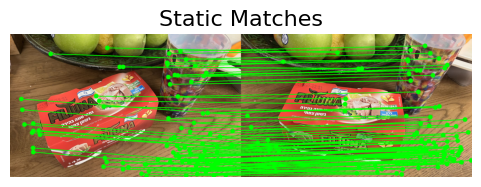

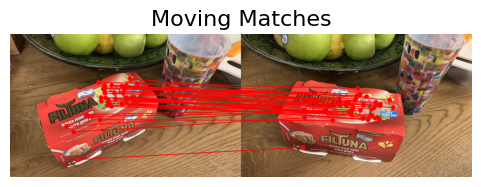

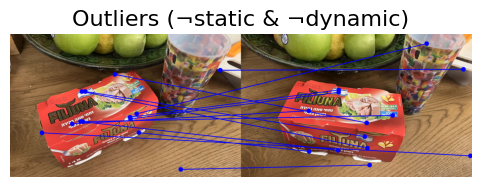

In [50]:
# ALL OF YOUR CODE FOR PART 3 SHOULD BE IN THIS CELL

# REQUIRED OUTPUTS (For each of the input stereo pairs in data/pairs_to_match):
# 1. Visualize matches
# 2. Visualize epipolar geometry
# 3. Visualize matches after constraints
import random
def filter_nearby_matches(kp1, matches, min_distance=20):
    filtered = []
    used = np.zeros(len(kp1), dtype=bool)

    for m in sorted(matches, key=lambda x: x.distance):  # sort by best first
        idx = m.queryIdx
        pt1 = np.array(kp1[idx].pt)

        # Skip if already close to a better keypoint
        if used[idx]:
            continue

        # Mark nearby keypoints as used
        for j, kp in enumerate(kp1):
            if not used[j] and np.linalg.norm(pt1 - np.array(kp.pt)) < min_distance:
                used[j] = True

        filtered.append(m)

    return filtered


def classify_matches_by_epipolar_and_distance(kp1, kp2, matches, F, static_threshold,lable):
    # Step 1: Convert matches to point pairs
    match_pts = [(kp1[m.queryIdx].pt, kp2[m.trainIdx].pt) for m in matches]

    # Step 2: Filter by Fundamental matrix
    filtered_pts = filter_matches_by_F(match_pts, F, threshold=static_threshold)

    labels = np.full(len(matches), 2)  # Default to outlier
    distances = []

    for i, match in enumerate(matches):
        pt1_xy = kp1[match.queryIdx].pt
        pt2_xy = kp2[match.trainIdx].pt
        pt_pair = (pt1_xy, pt2_xy)
        euclidean_distance = np.linalg.norm(np.array(pt1_xy) - np.array(pt2_xy))
        distances.append(euclidean_distance)

        if list(pt_pair) in filtered_pts:
            labels[i] = lable  



    return labels







def visualize_epipolar_classes(img1, img2, kp1, kp2, matches, labels, 
                               static_label=0, dynamic_label=1, outlier_label=2):
    # Stitch the two images side‐by‐side once
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    canvas_base = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas_base[:h1, :w1]       = img1
    canvas_base[:h2, w1:w1+w2]  = img2

    specs = [
        (static_label,  "Static Matches", (0,255,0)),
        (dynamic_label, "Moving Matches", (0,0,255)),
        (outlier_label, "Outliers (¬static & ¬dynamic)", (255,0,0)),
    ]

    for lbl, title, color in specs:
        canvas = canvas_base.copy()
        for m, l in zip(matches, labels):
            if l != lbl:
                continue
            x1, y1 = map(int, kp1[m.queryIdx].pt)
            x2, y2 = map(int, kp2[m.trainIdx].pt)
            p1 = (x1, y1)
            p2 = (x2 + w1, y2)
            cv2.circle(canvas, p1, 20, color, -1)
            cv2.circle(canvas, p2, 20, color, -1)
            cv2.line(  canvas, p1, p2, color, 5)

        plt.figure(figsize=(6, 6 * max(h1,h2)/(w1+w2)))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()


folder_path = 'data/pairs_to_segment'

# Get list of image files
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]


# Process image pairs
for i in range(0, len(image_files), 2):
    img1_path = os.path.join(folder_path, image_files[i])
    img2_path = os.path.join(folder_path, image_files[i + 1])

    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Initial SIFT matches
    kp1, kp2, matches = sift_init_match(img1, img2)
    matches = matches[:1000]
    if len(matches) >= 150:
        matches = random.sample(matches, 150)
    else:
        matches = matches  


    # Estimate Fundamental Matrix
    match_pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    match_pts2 = np.array([kp2[m.trainIdx].pt for m in matches])
    F, _ = ransac_fundamental_eight_point(match_pts1, match_pts2,iterations=3000)

    # Step 1: Classify static matches using initial F
    labels = classify_matches_by_epipolar_and_distance(kp1, kp2, matches, F, static_threshold=0.00635, lable=0)

    # Check if we have any static matches
    if np.sum(np.array(labels) == 0) == 0:
        print(f"No static matches in image pair {i} and {i+1}. Skipping non-static refinement.")

        # Mark everything as outlier (or 1 if you want to treat as all moving)
        final_labels = np.full(len(matches), 2)  # all outliers
    else:
        # Step 2: Extract non-static matches (not labeled 0)
        non_static_matches = [m for m, label in zip(matches, labels) if label != 0]

        # Step 3: Prepare points for RANSAC on non-static matches
        pts1_non_static = np.array([kp1[m.queryIdx].pt for m in non_static_matches])
        pts2_non_static = np.array([kp2[m.trainIdx].pt for m in non_static_matches])

        if len(pts1_non_static) >= 8:
            # Step 4: Compute new Fundamental matrix using RANSAC
            New_F, _ = ransac_fundamental_eight_point(pts1_non_static, pts2_non_static,iterations=3000)

            # Step 5: Classify non-static matches using new F
            threshold = 0.00635
            labels_non_static = np.full(len(non_static_matches), 2)  # default: outlier

            for j, m in enumerate(non_static_matches):
                pt1 = np.array(kp1[m.queryIdx].pt)
                pt2 = np.array(kp2[m.trainIdx].pt)

                pt1_h = np.array([pt1[0], pt1[1], 1.0])
                pt2_h = np.array([pt2[0], pt2[1], 1.0])

                error = pt2_h.T @ New_F @ pt1_h

                if abs(error) < threshold:
                    labels_non_static[j] = 1  # moving
                else:
                    labels_non_static[j] = 2  # outlier

            # Step 6: Merge labels into one final label array
            final_labels = np.full(len(matches), 2)

            # Assign static matches
            for j, label in enumerate(labels):
                if label == 0:
                    final_labels[j] = 0

            # Assign moving/outlier for non-static matches
            non_static_indices = [j for j, label in enumerate(labels) if label != 0]
            for idx, new_label in zip(non_static_indices, labels_non_static):
                final_labels[idx] = new_label
        else:
            print(f"Not enough non-static matches for RANSAC in image pair {i} and {i+1}.")
            # Only use original static/outlier classification
            final_labels = np.full(len(matches), 2)
            for j, label in enumerate(labels):
                if label == 0:
                    final_labels[j] = 0

    # Step 7: Visualize
    visualize_epipolar_classes(img1, img2, kp1, kp2, matches, final_labels,
                               static_label=0, dynamic_label=1, outlier_label=2)


    
    #Visualize epipolar geometry
    '''
    #Define some manual points (in 2D, shape: N x 2)
    manual_pts_img1 = np.array([[830, 460]])
    manual_pts_img2 = np.array([[1040, 535]])

    # Call the function with manual points
    points1, lines2, points2, lines1 = compute_epipolar_lines(
        img1, img2, F,
        num_points=10,
        manual_points1=manual_pts_img1,
        manual_points2=manual_pts_img2
    )
    draw_epipolar_lines(img1, img2, points1, lines2, points2, lines1)
    '''


### Explanation of your solution (short, in bullets) and interpretation of your results.

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>